## Code visibility
Use the Show/Hide Code button on the top left to make to make the code visible or hide it. It will be hidden in the HTML files by default.

If a code cell starts with 
```python
# RUN
```
Run the cell by CTRL+Enter, or the Run button above.  

If a code cell starts with
```python
# USER INPUT
```
User input is needed before running the cell, so make sure that the file names and settings included in the cell are appropriate for your run.

If a code cell starts with
```python
# OPTIONAL USER INPUT
```
User input is needed before running the cell. However, some defaults are provided, so make sure that either the settings will work for your run, or change them appropriately.

In [1]:
# RUN
import sys
sys.path.append("/opt/src")
import mip_functions as mip
import pickle
import json
import copy
import os
import numpy as np
import subprocess
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
wdir = "/opt/analysis/"
data_dir = "/opt/data/"

Classes reloading.
functions reloading


In [2]:
# USER INPUT

# provide the MIPWrangler output files
# which must be located in the /opt/data directory within the container.
# if more than one run is to be merged, provide all files
info_files = ["testing_JJJ_DR1_VAR4_20191015.txt.gz"] 

# sample sheets associated with each wrangler file,
# in the same order as the wrangler files.
sample_sheets = ["sample_list.tsv"]

# No input below
info_files = [data_dir + i for i in info_files]
sample_sheets = [data_dir + s for s in sample_sheets]
pd.concat([pd.read_table(s) for s in sample_sheets],
         ignore_index=True).groupby(["sample_set", "probe_set"]).first()

,,sample_name,replicate,fw,rev,owner,Capture Plate Name,Capture Plate Location,Library Prep,Sample Set
sample_set,probe_set,,,,,,,,,
JJJ,"DR1,VAR4",D10,1,93,93,Zack,Plate_1,H9,171025,CTL


The above table shows the unique sample_set, probe_set combinations in the sample sheets provided. Select which combinations should be used for this analysis.

If more than one combination is to be used, the input will be a list of lists, for example:
```python
sample_groups = [["sample_set_1", "probe_set_1"], ["sample_set_2", "probe_set_2"]]
```

In [3]:
# USER INPUT
sample_groups = [["JJJ", "DR1,VAR4"]]

### Specify the species and the probe set used
These two are important parameters to determine which files will be used for analysis.  


For the species, the options are: "pf" for *Plasmodium falciparum*, "pv" for *Plasmodium vivax*, "hg19" for *Homo sapiens* genome assembly hg19/GRCh37 and "hg38" for *Homo sapiens* genome assembly hg38/GRCh38  
___
Probe sets also must be specified. Check the output of the sample sheet summary above under **probe_set** field for a reminder of what the probe set of interest is. This is usually a three letter code or codes separated by a comma. For example,  
```python
species = "pf"
probe_sets_used = "DR1,VAR4"
```

In [4]:
# USER INPUT
species =  "pf"
probe_sets_used = "DR1,VAR4"

In [5]:
# OPTIONAL USER INPUT
# available cpu count
processorNumber = 20

# Are there specific targets for which negative data should be included?
# Setting this to 1 forces variant calls on taret positions even
# if all samples are invariant.
targetJoin = 1

## extra bwa options for haplotype alignment
# "-a" for getting all alignments
# "-L 500" to penalize soft clipping 
bwaExtra = ["-a", "-L 500", "-t", str(processorNumber)]
##############      SETTINGS FOR DATA FILTERS    ##################
###################################################################
###################################################################
# Phred quality filter for individual variants. This is not used
# per variant overall, but within each sample for each variant.
minVariantQuality = 20
minVariantCoverage = 1
minVariantCount = 1
# Merge nucleotide changes happening on the same codon to convert t
# Use only for Plasmodium
mergeSNPs = 0

### Get/Set the analysis settings
Use the settings template for the species specified to get the  analysis settings and change the vaules specified in the above cell. This will create a template_settings.txt file in your analysis directory and a settings.txt file to be used for the analysis. These files also will serve as a reference of analysis settings for the sake of reproducibility.

In [16]:
# RUN

# copy the template settings file
temp_settings_file = "/opt/resources/templates/analysis_settings_templates/settings.txt"
subprocess.call(["scp", temp_settings_file, "/opt/analysis/template_settings.txt"])

# extract the settings template
temp_settings = mip.get_analysis_settings("/opt/analysis/template_settings.txt")

# update bwa settings with processor count
bwaOptions = temp_settings["bwaOptions"]
try:
    bwaOptions.extend(bwaExtra)
except AttributeError:
    bwaOptions = [bwaOptions]
    bwaOptions.extend(bwaExtra)

# Create a list from the probe_sets string
mipSetKey = probe_sets_used.split(",") + [""]

# create a dictionary for which settings should be updated
# using the user specified parameters.
update_keys = {"mipSetKey" : mipSetKey, 
               "minVariantCoverage": minVariantCoverage,
               "minVariantCount": minVariantCount,
               "minVariantQuality": minVariantQuality,
               "mergeSNPs": mergeSNPs,
               "processorNumber": processorNumber,
              "bwaOptions": bwaOptions,
              "targetJoin": targetJoin,
              "species": species}
# update the settings
for k, v in update_keys.items():
    temp_settings[k] = v
# create a settings file in the analysis directory.
settings_file = "settings.txt"
settings_path = os.path.join(wdir, settings_file)
mip.write_analysis_settings(temp_settings, settings_path)
settings = mip.get_analysis_settings(wdir + settings_file)
# create probe sets dictionary
mip.update_probe_sets("/opt/project_resources/mip_ids/mipsets.csv",
                     "/opt/project_resources/mip_ids/probe_sets.json")

### Specify if there is a target file.
Targets file is project specific. Its default location is project_resources/ directory. For a target file project_resources/targets.tsv use:
```Python
targets_file = "/opt/project_resources/targets.tsv" 
```
If targets file is not available, **targets_file = None** should be used.  
```Python
targets_file = None
```

In [17]:
# OPTIONAL USER INPUT
targets_file = "/opt/project_resources/targets.tsv" 

### Specify how we want to add the "targeted locus" information to experiment results.
You can use:  
1. **target_join=intersection**: Filter variants so that only those in the initial targets list will remain. Annotate the variants with the information from targets file.  
2. **target_join=data**: Keep all variants in the data and annotate.  
3. **target_join=targets**: Keep only the variants in the target list (even if the variant is not observed in the data). This is useful when we're interested in knowing when a variant is not observed, such as drug resistance mutations.  
4. **target_join=union**: Keep all variants, annotate, add variants from targets file even if not observed.

In [18]:
# OPTIONAL USER INPUT
target_join = "union"

In [20]:
# RUN
if len(info_files) > 1:
    mip.combine_info_files(wdir,
                           settings_file, 
                          info_files,
                          sample_sheets,
                          settings["mipsterFile"],
                          sample_sets=sample_groups)
else:
    mip.process_info_file(wdir,
                          settings_file, 
                          info_files,
                          sample_sheets,
                          settings["mipsterFile"],
                          sample_sets=sample_groups)

## Variant calling using pairwise alignment
This is the default variant calling algorithm of MIPTools pipeline. It aligns  each haplotype sequence to the reference sequence for a given MIP (pairwise). It generates variant coverage tables as well as vcf files. Vcf files **do not include indels**.

In [21]:
mip.process_haplotypes(wdir + settings_file)
mip.process_results(wdir,
                    settings_file,
                    [wdir + "samples.tsv"],
                    targets_file=targets_file,
                    target_join=target_join
                   )

56 out of 56 samples has meta information and will be used for analysis.
There are 1198 mapped and 5 unmapped (off target) haplotypes.
There are 5696 data points in raw data, 5691 are mapped to genome and their targets.
Total number of reads and barcodes were 430529 and 156704. On target number of reads and barcodes were 430515 and 156699.
There were 15872 total and 2398 unique variants, 
15872 total and 2398 unique variants remain after filtering variants for minimum total barcodes of 1, minimum observed sample number of 1, and minimum observed sample fraction of 0.0.
12437 total and 1181 unique variants remained after quality filtering for phred scores >= 20.
There are 52 samples with sequence data
There are 56 total samples.
Per sample mutation frequencies have been calculated for mutants with at least 2 supporting barcodes and loci with at least 5 coverage. Loci with less coverage will have NA frequencies and mutants with less supporting barcodes have been reset to zero frequency.


### Preview the results
Plotting the probe coverage by samples is a good  way to see overall experiment perfomance. It shows if a probe has at least 1 barcode (or however many is specified below) for a given sample.  

Dark columns point to poor performing probes whereas dark rows indicate poor samples. Note that this excludes samples with no reads at all. Use "all_barcode_counts.csv" file if those are of interest as well.

Some parameters can be supplied to the plotting function as noted in the comments.

(<Figure size 1800x1200 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3a2656ec50>)

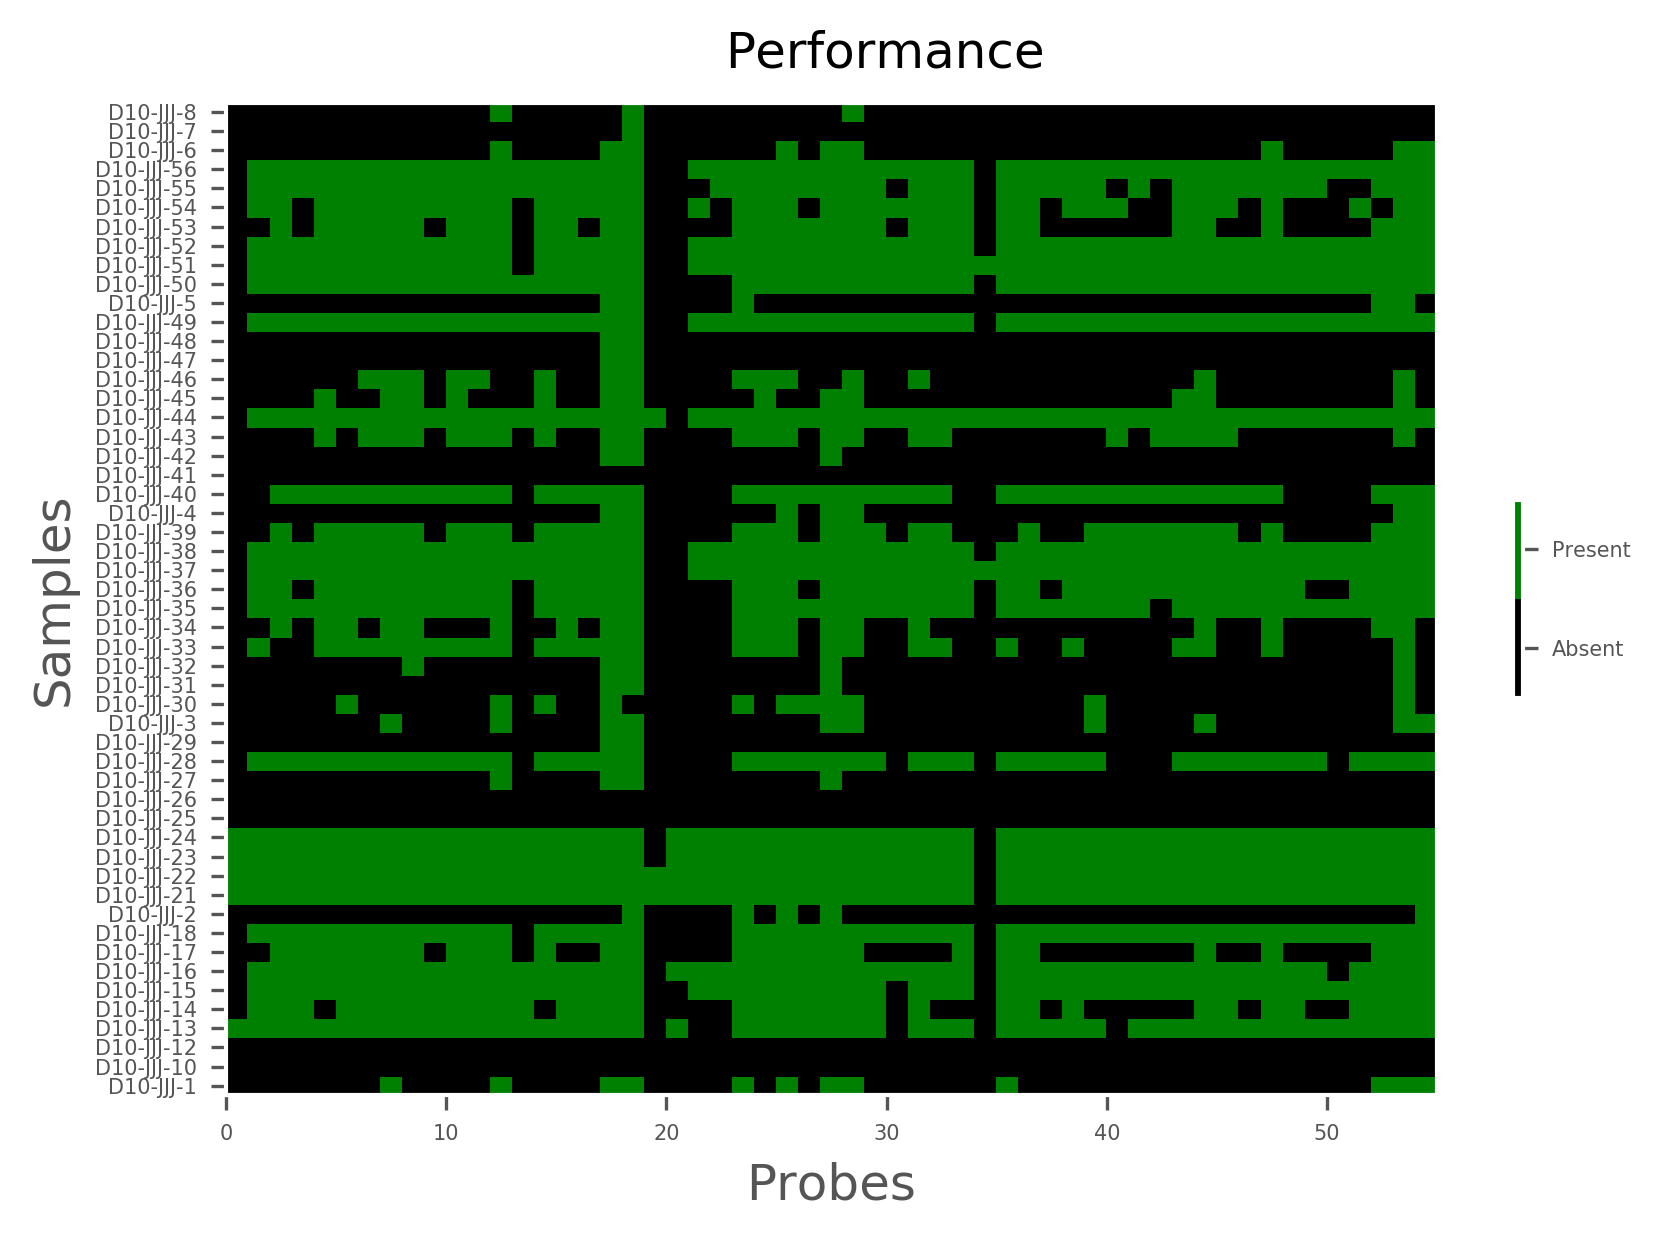

In [41]:
# OPTIONAL USER INPUT
barcode_counts = pd.read_csv(wdir + "barcode_counts.csv",
             header = [0,1], index_col = 0)
mip.plot_performance(barcode_counts,
                     barcode_threshold=10, # anything below this number will be considered absent
                     tick_label_size=5, # font size for tick labels for x and y axis
                     cbar_label_size=5, # font size for heat map color bar
                     dpi=300, # figure resolution
                     absent_color='black',
                     present_color='green',
                     save=False, # If false, plots the graph here. If true, saves a .png in the analysis dir
                    ytick_freq=None, # How frequent the y-axis ticks should be (every nth column will have  a tick)
                    xtick_freq=None,
                    xtick_rotation=90) # x-axis tick label rotation 

### Look at summary stats 
There are summary statistics and meta data (if provided) we can use to determine if coverage is enough, whether further sequencing is necessary, and how to proceed if further sequencing will be needed.

In [42]:
# RUN
sample_summary = pd.read_csv(wdir + "sample_summary.csv")
sample_summary.head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes
0,D10-JJJ-1,828.0,339.0,48,31,12
1,D10-JJJ-10,1.0,1.0,1,0,0
2,D10-JJJ-12,15.0,5.0,5,0,0
3,D10-JJJ-13,4918.0,3189.0,54,54,49
4,D10-JJJ-14,1436.0,1252.0,54,47,35


In [43]:
# RUN
meta = pd.read_csv(wdir + "merged_meta.csv")
meta.head()

,Unnamed: 0,Sample ID,Library Prep,sample_name,probe_set,replicate,fw,rev,owner,Capture Plate Name,Capture Plate Location,sheet_order,sample_set,Original SID,Sample Name,Meta
0,0,D10-JJJ-1,171025,D10,"DR1,VAR4",1,93,93,Zack,Plate_1,H9,0,JJJ,D10-JJJ-1,D10,Meta
1,1,D10-JJJ-10,171025,D10,"DR1,VAR4",10,92,188,Travis,Plate_5,H8,0,JJJ,D10-JJJ-10,D10,Meta
2,2,D10-JJJ-11,171025,D10,"DR1,VAR4",11,187,283,Travis,Plate_6,H7,0,JJJ,D10-JJJ-11,D10,Meta
3,3,D10-JJJ-12,171025,D10,"DR1,VAR4",12,188,284,Travis,Plate_6,H8,0,JJJ,D10-JJJ-12,D10,Meta
4,4,D10-JJJ-13,171025,D10,"DR1,VAR4",13,283,379,Zack,Plate_7,H7,0,JJJ,D10-JJJ-13,D10,Meta


### A scatter plot of total barcode count vs number of probes covered at a certain barcode count is a good way to see how the relationship between total coverage and probe coverage, which is useful in determining how to proceed to the next experiments or analyses.

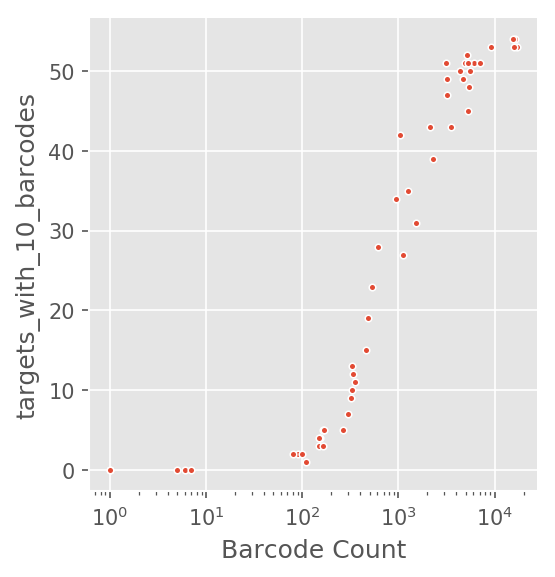

In [44]:
# RUN
f = sns.pairplot(data = sample_summary,
                x_vars = "Barcode Count",
                y_vars = "targets_with_10_barcodes",
                plot_kws={"s": 10})
f.fig.set_size_inches(5,5)
f.fig.set_dpi(150)
f.fig.axes[0].set_xscale("log")

### Plot the total read count vs the covered probe number

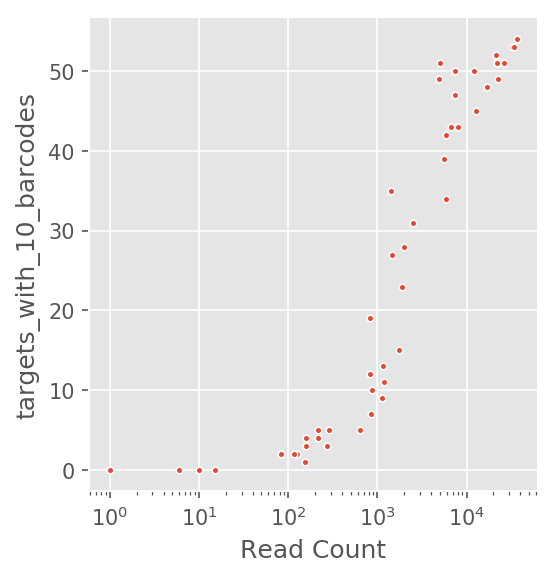

In [45]:
# RUN
f = sns.pairplot(data = sample_summary,
                x_vars = "Read Count",
                y_vars = "targets_with_10_barcodes",
                plot_kws={"s": 10})
f.fig.set_size_inches(5,5)
f.fig.set_dpi(150)
f.fig.axes[0].set_xscale("log")

### Repooling capture reactions for further sequencing. Factors to consider:
1. What do you we want to accomplish? In most cases, we would like to get enough coverage for a number of probes for each sample. For example, the test data contains **50 probes** in total. Let's say it is sufficient if we had a coverage of **10** or more for each probe for a sample. Then, we would not want to sequence any more of that sample. 
```python
target_coverage_count = 50
target_coverage_key='targets_with_10_barcodes'
```
Alternatively, we can set a goal of a fraction of total probes to reach a certain coverage rather than an absolute number of probes. For 95% of the maximum number of probes observed (47 in this case): 
```python
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
```
Although we set our goal to 47 probes, it is likely that some sample will never reach that number regardless of how much we sequence, if there is a deletion in the region, for example. So it makes sense to set a total coverage threshold after which we don't expect more data. Looking at the plot above, it seems like after 1000 barcode counts, we would reach our goal for most samples. 
```python
high_barcode_threshold = 10000
```
Another metric to use for determining if we want to sequence a sample more is the average read count per barcode count. This value indicates we have sequenced each unique molecular index in our sample so many times, so when the value is high, it is unlikely that we'd get more UMIs by sequencing the same library more. It makes more sense for a fresh MIP capture from these samples if more data is needed.
```python
barcode_coverage_threshold=10
```
Some samples perform very poorly for one reason or another. There are two options for these samples for repooling consideration: 1) Repool as much as we can for the next run, 2) Assuming there is a problem in the capture reaction, set up a new MIP capture reaction for these samples. It makes more sense to use option 1 if this is the first sequencing data using this library. Use option 2 if this library have been repooled at a higher volume already, but still producing poor data.
```python
barcode_count_threshold=100 # samples below total barcode count of this value is considered low coverage
low_coverage_action='Repool' # what to do for low coverage samples (Repool or Recapture)
```
Sometimes a handful of samples show uneven coverage of loci, i.e. they have very good coverage of a handful of loci but poor coverage in others, which may point to a problem with the sample or the experiment in general. These samples are determined by comparing the subset of samples that reached the goal we set (completed samples) and those that have not. We look at the number of barcodes per probe for _completed_ samples and get 25th percentile (or other percentile as set) and assume that if a sample on average has this many barcodes per target, it should have reached the set goal. For example, if on average _completed_ samples, i.e. samples that cover 47 probes at 10 barcodes or more, have 10000 total barcodes, they would have ~200 (10000/47) barcodes per target covered. And if an _incomplete_ sample has 5000 total barcodes and only 10 targets covered, this value would be 500 for that sample and it would be flagged as **uneven coverage** in repooling document.
```python
assesment_key='targets_with_1_barcodes' # coverage key to compare "complete" and "incomplete" samples
good_coverage_quantile=0.25 # percentile to set the threshold
```

In [46]:
# USER INPUT
high_barcode_threshold = 10000
target_coverage_count = None
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
barcode_coverage_threshold=10
barcode_count_threshold=100
low_coverage_action='Recapture'
assesment_key='targets_with_1_barcodes'
good_coverage_quantile=0.25

In [47]:
# RUN
data_summary = pd.merge(sample_summary, meta)
mip.repool(wdir, 
           data_summary, 
           high_barcode_threshold, 
           target_coverage_count=target_coverage_count, 
           target_coverage_fraction=target_coverage_fraction, 
           target_coverage_key=target_coverage_key,
           barcode_coverage_threshold=barcode_coverage_threshold,
           barcode_count_threshold=barcode_count_threshold, 
           low_coverage_action=low_coverage_action,
           assesment_key=assesment_key,
           good_coverage_quantile=good_coverage_quantile,
           output_file='repool.csv')

Out of 52 samples 6 are completed, 7 will be recaptured and 39 repooled
0 samples showed uneven coverage, 0 complete, 0 to be recaptured, 0 repooled


### Inspect the repool document
Library to completion field in the repool document has the value (volume) of how much from a sample should be pooled for re-sequencing. These values are only rough estimates and care should be taken to make sure there will be enough material to sequence.

In [48]:
pd.read_csv(wdir + "repool.csv").head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes,Unnamed: 0,Library Prep,sample_name,probe_set,...,Original SID,Sample Name,Meta,total_barcode_count,total_read_count,Status,Barcode Coverage,Library to Completion,Barcodes Per Target Covered,Uneven Coverage
0,D10-JJJ-1,828.0,339.0,48,31,12,0,171025,D10,"DR1,VAR4",...,D10-JJJ-1,D10,Meta,339.0,828.0,Repool,2.442478,28.498525,28.250000,False
1,D10-JJJ-10,1.0,1.0,1,0,0,1,171025,D10,"DR1,VAR4",...,D10-JJJ-10,D10,Meta,1.0,1.0,Recapture,1.000000,9999.000000,NaN,False
2,D10-JJJ-12,15.0,5.0,5,0,0,3,171025,D10,"DR1,VAR4",...,D10-JJJ-12,D10,Meta,5.0,15.0,Recapture,3.000000,1999.000000,NaN,False
3,D10-JJJ-13,4918.0,3189.0,54,54,49,4,171025,D10,"DR1,VAR4",...,D10-JJJ-13,D10,Meta,3189.0,4918.0,Repool,1.542176,2.135779,65.081633,False
4,D10-JJJ-14,1436.0,1252.0,54,47,35,5,171025,D10,"DR1,VAR4",...,D10-JJJ-14,D10,Meta,1252.0,1436.0,Repool,1.146965,6.987220,35.771429,False


### Lets look at some files generated from the data
**variant_table.csv** file in your analysis directory contains all the variants passing filters specified in the settings file. The values in the table are each variant's ALT allele barcode depth in a given sample. Note that the value in paranthesis **range(12)** must match the number of header lines in the file. This depends on how many information fields from targets file are retained for final analysis. Experiment with values (9-12) to get the correct value that leaves only the numbers/values in the table and all other information on the column headers.

In [49]:
variant_counts = pd.read_csv(
    wdir + "variant_table.csv", 
    header = list(range(12)), index_col = 0
)
variant_counts.head()

CHROM                             chr1                                    \
POS                           266695.0         266697.0         266699.0   
ID                                   .                .                .   
REF                                 TA                A                A   
ALT                                  T                C                C   
Gene                              atp6             atp6             atp6   
Mutation Name            atp6-Asn827fs       atp6-I826S       atp6-N825K   
AA Change Position                 826              826              825   
ExonicFunc          frameshift_variant missense_variant missense_variant   
Reference Resistant                 No               No               No   
Targeted                            No               No               No   
Multi Mapping                       No               No               No   
Sample ID                                                                  
D10-JJJ-1                          0.0              0.0              0.0   
D10-JJJ-12                         0.0              0.0              0.0   
D10-JJJ-13                         0.0              0.0              0.0   
D10-JJJ-14                         0.0              0.0              0.0   
D10-JJJ-15                         0.0              0.0              0.0   

CHROM                                                                     \
POS                           266705.0         266711.0         266712.0   
ID                                   .                .                .   
REF                                  A                A                A   
ALT                                  C                C                C   
Gene                              atp6             atp6             atp6   
Mutation Name               atp6-G823G       atp6-I821M       atp6-I821S   
AA Change Position                 823              821              821   
ExonicFunc          synonymous_variant missense_variant missense_variant   
Reference Resistant                 No               No               No   
Targeted                            No               No               No   
Multi Mapping                       No               No               No   
Sample ID                                                                  
D10-JJJ-1                          0.0              0.0              0.0   
D10-JJJ-12                         0.0              0.0              0.0   
D10-JJJ-13                         0.0              0.0              0.0   
D10-JJJ-14                         0.0              0.0              0.0   
D10-JJJ-15                         0.0              0.0              0.0   

CHROM                                                                   \
POS                         266715.0         266717.0         266718.0   
ID                                 .                .                .   
REF                                A                A                A   
ALT                                C                C                C   
Gene                            atp6             atp6             atp6   
Mutation Name             atp6-M820R       atp6-F819L       atp6-F819C   
AA Change Position               820              819              819   
ExonicFunc          missense_variant missense_variant missense_variant   
Reference Resistant               No               No               No   
Targeted                          No               No               No   
Multi Mapping                     No               No               No   
Sample ID                                                                
D10-JJJ-1                        0.0              0.0              0.0   
D10-JJJ-12                       0.0              0.0              0.0   
D10-JJJ-13                       0.0              0.0              0.0   
D10-JJJ-14                       0.0              0.0              0.0   
D10-

**variant_coverage_table.csv** file has the same structure as the variant_table file. The values in this table has the _total coverage_ for the locus of each variant in each sample.

In [50]:
variant_coverage = pd.read_csv(
    wdir + "variant_coverage_table.csv", 
    header = list(range(12)), index_col = 0
)
variant_coverage.head()

CHROM                             chr1                                    \
POS                           266695.0         266697.0         266699.0   
ID                                   .                .                .   
REF                                 TA                A                A   
ALT                                  T                C                C   
Gene                              atp6             atp6             atp6   
Mutation Name            atp6-Asn827fs       atp6-I826S       atp6-N825K   
AA Change Position                 826              826              825   
ExonicFunc          frameshift_variant missense_variant missense_variant   
Reference Resistant                 No               No               No   
Targeted                            No               No               No   
Multi Mapping                       No               No               No   
Sample ID                                                                  
D10-JJJ-1                          1.0              1.0              1.0   
D10-JJJ-12                         0.0              0.0              0.0   
D10-JJJ-13                        15.0             15.0             15.0   
D10-JJJ-14                        16.0             16.0             16.0   
D10-JJJ-15                        22.0             22.0             22.0   

CHROM                                                                     \
POS                           266705.0         266711.0         266712.0   
ID                                   .                .                .   
REF                                  A                A                A   
ALT                                  C                C                C   
Gene                              atp6             atp6             atp6   
Mutation Name               atp6-G823G       atp6-I821M       atp6-I821S   
AA Change Position                 823              821              821   
ExonicFunc          synonymous_variant missense_variant missense_variant   
Reference Resistant                 No               No               No   
Targeted                            No               No               No   
Multi Mapping                       No               No               No   
Sample ID                                                                  
D10-JJJ-1                          1.0              1.0              1.0   
D10-JJJ-12                         0.0              0.0              0.0   
D10-JJJ-13                        15.0             15.0             15.0   
D10-JJJ-14                        16.0             16.0             16.0   
D10-JJJ-15                        22.0             22.0             22.0   

CHROM                                                                   \
POS                         266715.0         266717.0         266718.0   
ID                                 .                .                .   
REF                                A                A                A   
ALT                                C                C                C   
Gene                            atp6             atp6             atp6   
Mutation Name             atp6-M820R       atp6-F819L       atp6-F819C   
AA Change Position               820              819              819   
ExonicFunc          missense_variant missense_variant missense_variant   
Reference Resistant               No               No               No   
Targeted                          No               No               No   
Multi Mapping                     No               No               No   
Sample ID                                                                
D10-JJJ-1                        1.0              1.0              1.0   
D10-JJJ-12                       0.0              0.0              0.0   
D10-JJJ-13                      15.0             15.0             15.0   
D10-JJJ-14                      16.0             16.0             16.0   
D10-

#### We can easily get within sample allele frequency of each variant by dividing variant table by coverage table.  

In [51]:
freq_table = variant_counts/variant_coverage
freq_table.head()

CHROM                             chr1                                    \
POS                           266695.0         266697.0         266699.0   
ID                                   .                .                .   
REF                                 TA                A                A   
ALT                                  T                C                C   
Gene                              atp6             atp6             atp6   
Mutation Name            atp6-Asn827fs       atp6-I826S       atp6-N825K   
AA Change Position                 826              826              825   
ExonicFunc          frameshift_variant missense_variant missense_variant   
Reference Resistant                 No               No               No   
Targeted                            No               No               No   
Multi Mapping                       No               No               No   
Sample ID                                                                  
D10-JJJ-1                          0.0              0.0              0.0   
D10-JJJ-12                         NaN              NaN              NaN   
D10-JJJ-13                         0.0              0.0              0.0   
D10-JJJ-14                         0.0              0.0              0.0   
D10-JJJ-15                         0.0              0.0              0.0   

CHROM                                                                     \
POS                           266705.0         266711.0         266712.0   
ID                                   .                .                .   
REF                                  A                A                A   
ALT                                  C                C                C   
Gene                              atp6             atp6             atp6   
Mutation Name               atp6-G823G       atp6-I821M       atp6-I821S   
AA Change Position                 823              821              821   
ExonicFunc          synonymous_variant missense_variant missense_variant   
Reference Resistant                 No               No               No   
Targeted                            No               No               No   
Multi Mapping                       No               No               No   
Sample ID                                                                  
D10-JJJ-1                          0.0              0.0              0.0   
D10-JJJ-12                         NaN              NaN              NaN   
D10-JJJ-13                         0.0              0.0              0.0   
D10-JJJ-14                         0.0              0.0              0.0   
D10-JJJ-15                         0.0              0.0              0.0   

CHROM                                                                   \
POS                         266715.0         266717.0         266718.0   
ID                                 .                .                .   
REF                                A                A                A   
ALT                                C                C                C   
Gene                            atp6             atp6             atp6   
Mutation Name             atp6-M820R       atp6-F819L       atp6-F819C   
AA Change Position               820              819              819   
ExonicFunc          missense_variant missense_variant missense_variant   
Reference Resistant               No               No               No   
Targeted                          No               No               No   
Multi Mapping                     No               No               No   
Sample ID                                                                
D10-JJJ-1                        0.0              0.0              0.0   
D10-JJJ-12                       NaN              NaN              NaN   
D10-JJJ-13                       0.0              0.0              0.0   
D10-JJJ-14                       0.0              0.0              0.0   
D10-

Genotypes can also be generated using these frequencies and some count filters.  
Possible filters:    
1.  **min_coverage**: how many barcodes are needed to for a genomic position for a sample to reliable call (possible mixed or heterozygous) genotypes. If we set min_coverage = 10, any locus within a sample that is covered below this threshold will have an NA genotype.
2.  **min_count**: if a genomic position have enough coverage, how many barcodes supporting an ALT (non-REF) base call is needed for a reliable call. If we set min_count = 2, any variant with an ALT call that has less than 2 barcodes supporting the ALT call will revert to REF.
3.  **min_freq**: a minimum within sample allele frequency threshold to consider a variant valid. If set to 0.01, for example, a variant locus in a sample that is at 0.005 frequency for the ALT allele within the sample, the locus would be called REF, if the within sample AF is between 0.01 and 0.99, it would be considered HET, and if > 0.99, it would be homozygous ALT.
```Python
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
variant_counts = variant_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
variant_coverage = variant_coverage.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = variant_counts / variant_coverage
# call genotypes using the minimum within sample allele frequency parameter from the settings file
geno = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                     else 0 if x < min_freq
                     else 1 if x < (1 - min_freq)
                     else 2)
```

### Amino acid changes
While variant specific files have information on base changes, there are also files that deal with amino acid changes only, referred to as mutations here as opposed to variants.  

The main difference between two types of data is that while two variants that are leading to the same amino acid change are considered separate variants, they would constitute the **same** mutation. A sample may have, for example, multiple distinct variants that correspond to the same *mutation* and all counts for those variants would be counted cumulatively for the single mutation call.  

Another important distinction between the variants and mutations is that the variants only deal with REF and ALT alleles. While mutations are classified as MUT or WT. While most of the time the ALT allele corresponds to the MUT call, it is sometimes possible that the REF allele encodes a mutation. The only example we have for this so far is the dhps-A437G allele which encodes a drug resistance mutation, Alanine being the WT allele and Glycine the drug resistant mutant. The 3d7 reference strain has the G allele. So when dealing with *variants* the A allele would be the ALT and G the REF, but they would be reversed to A:WT and G:MUT for mutation calls. This must be specified in the targets file by setting the "Reference Resistant" column value to "Yes".

### Below we'll preview the count, coverage and genotype files for the *mutations*
First, alternate allele counts.

In [52]:
mutation_counts = pd.read_csv(wdir + "mutant_table.csv",
                           index_col=0, header=list(range(4)))
mutation_counts.head()

Gene                           PF3D7-1322700                         \
Mutation Name PF3D7-1322700-Asn268_Tyr279del PF3D7-1322700-Asn276fs   
Targeted                                  No                     No   
ExonicFunc     conservative_inframe_deletion     frameshift_variant   
Sample ID                                                             
D10-JJJ-1                                0.0                    0.0   
D10-JJJ-12                               0.0                    0.0   
D10-JJJ-13                              13.0                    0.0   
D10-JJJ-14                               7.0                    0.0   
D10-JJJ-15                               7.0                    0.0   

Gene                                                      \
Mutation Name PF3D7-1322700-Gly259fs PF3D7-1322700-T236I   
Targeted                          No                 Yes   
ExonicFunc        frameshift_variant                  NA   
Sample ID                                                  
D10-JJJ-1                        0.0                 0.0   
D10-JJJ-12                       0.0                 0.0   
D10-JJJ-13                       0.0                 0.0   
D10-JJJ-14                       0.0                 0.0   
D10-JJJ-15                       0.0                 0.0   

Gene                                       PF3D7-1451200                     \
Mutation Name PF3D7-1322700-Thr278fs PF3D7-1451200-D139N PF3D7-1451200-G76V   
Targeted                          No                  No                 No   
ExonicFunc        frameshift_variant    missense_variant   missense_variant   
Sample ID                                                                     
D10-JJJ-1                        0.0                 0.0                0.0   
D10-JJJ-12                       0.0                 0.0                0.0   
D10-JJJ-13                       0.0                 0.0                0.0   
D10-JJJ-14                       0.0                 0.0                0.0   
D10-JJJ-15                       0.0                 0.0                0.0   

Gene                                                                         \
Mutation Name PF3D7-1451200-I129S PF3D7-1451200-Ile160fs PF3D7-1451200-N71N   
Targeted                       No                     No                Yes   
ExonicFunc       missense_variant     frameshift_variant                 NA   
Sample ID                                                                     
D10-JJJ-1                     0.0                    0.0                0.0   
D10-JJJ-12                    0.0                    0.0                0.0   
D10-JJJ-13                    1.0                    0.0                0.0   
D10-JJJ-14                    0.0                    0.0                0.0   
D10-JJJ-15                    0.0                    0.0                0.0   

Gene                              ...                                win54  \
Mutation Name                     ...                          win54-S153A   
Targeted                          ...                                   No   
ExonicFunc                        ...                     missense_variant   
Sample ID                         ...                                        
D10-JJJ-1                         ...                                  0.0   
D10-JJJ-12                        ...                                  0.0   
D10-JJJ-13                        ...                                  0.0   
D10-JJJ-14                        ...                                  0.0   
D10-JJJ-15                        ...                                  0.0   

Gene                                                                         \
Mutation Name      win54-S154R      win54-S156A win54-Ser144* win54-Ser153*   
Targeted                    No               No            No            No   
ExonicFunc    missense_variant missense_variant   stop_gained   stop_gained   
Sample ID

### Coverage

In [53]:
mutation_coverage = pd.read_csv(wdir + "mutant_coverage.csv",
                           index_col=0, header=list(range(4)))
mutation_coverage.head()

Gene                           PF3D7-1322700                         \
Mutation Name PF3D7-1322700-Asn268_Tyr279del PF3D7-1322700-Asn276fs   
Targeted                                  No                     No   
ExonicFunc     conservative_inframe_deletion     frameshift_variant   
Sample ID                                                             
D10-JJJ-1                                0.0                    0.0   
D10-JJJ-12                               0.0                    0.0   
D10-JJJ-13                              13.0                   13.0   
D10-JJJ-14                               7.0                    7.0   
D10-JJJ-15                               7.0                    7.0   

Gene                                                      \
Mutation Name PF3D7-1322700-Gly259fs PF3D7-1322700-T236I   
Targeted                          No                 Yes   
ExonicFunc        frameshift_variant                  NA   
Sample ID                                                  
D10-JJJ-1                        0.0                 0.0   
D10-JJJ-12                       0.0                 0.0   
D10-JJJ-13                      13.0                13.0   
D10-JJJ-14                       7.0                 7.0   
D10-JJJ-15                       7.0                 7.0   

Gene                                       PF3D7-1451200                     \
Mutation Name PF3D7-1322700-Thr278fs PF3D7-1451200-D139N PF3D7-1451200-G76V   
Targeted                          No                  No                 No   
ExonicFunc        frameshift_variant    missense_variant   missense_variant   
Sample ID                                                                     
D10-JJJ-1                        0.0                 6.0                6.0   
D10-JJJ-12                       0.0                 0.0                0.0   
D10-JJJ-13                      13.0                26.0               26.0   
D10-JJJ-14                       7.0                34.0               34.0   
D10-JJJ-15                       7.0                34.0               34.0   

Gene                                                                         \
Mutation Name PF3D7-1451200-I129S PF3D7-1451200-Ile160fs PF3D7-1451200-N71N   
Targeted                       No                     No                Yes   
ExonicFunc       missense_variant     frameshift_variant                 NA   
Sample ID                                                                     
D10-JJJ-1                     6.0                    6.0                6.0   
D10-JJJ-12                    0.0                    0.0                0.0   
D10-JJJ-13                   26.0                   26.0               26.0   
D10-JJJ-14                   34.0                   34.0               34.0   
D10-JJJ-15                   34.0                   34.0               34.0   

Gene                              ...                                win54  \
Mutation Name                     ...                          win54-S153A   
Targeted                          ...                                   No   
ExonicFunc                        ...                     missense_variant   
Sample ID                         ...                                        
D10-JJJ-1                         ...                                 11.0   
D10-JJJ-12                        ...                                  0.0   
D10-JJJ-13                        ...                                147.0   
D10-JJJ-14                        ...                                 60.0   
D10-JJJ-15                        ...                                194.0   

Gene                                                                         \
Mutation Name      win54-S154R      win54-S156A win54-Ser144* win54-Ser153*   
Targeted                    No               No            No            No   
ExonicFunc    missense_variant missense_variant   stop_gained   stop_gained   
Sample ID

**Genotypes** for mutations can also be generated in a similar way to the genotypes for variants.  
Possible filters:    
1.  **min_coverage**: how many barcodes are needed to for a genomic position for a sample to reliable call (possible mixed or heterozygous) genotypes. If we set min_coverage = 10, any locus within a sample that is covered below this threshold will have an NA genotype.
2.  **min_count**: if a genomic position have enough coverage, how many barcodes supporting an MUT (non-WT) aminoacid call is needed for a reliable call. If we set min_count = 2, any mutation with an MUT call that has less than 2 barcodes supporting the MUT call will revert to WT.
3.  **min_freq**: a minimum within sample allele frequency threshold to consider a variant valid. If set to 0.01, for example, a variant locus in a sample that is at 0.005 frequency for the MUT allele within the sample, the locus would be called WT, if the within sample AF is between 0.01 and 0.99, it would be considered HET, and if > 0.99, it would be homozygous MUT.
```Python
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
mutation_counts = mutation_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
mutation_coverage = mutation_coverage.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = mutation_counts / mutation_coverage
# call genotypes using the minimum within sample allele frequency parameter from the settings file
geno = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                     else 0 if x < min_freq
                     else 1 if x < (1 - min_freq)
                     else 2)
```

A genotypes.csv file is already generated using the cut off values provided in the settings file.

In [54]:
min_count = 2
min_coverage = 10
min_freq = 0.01
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
mutation_counts = mutation_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
mutation_coverage = mutation_coverage.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = mutation_counts / mutation_coverage
# call genotypes using the minimum within sample allele frequency parameter from the settings file
genotypes = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                 else 0 if x < min_freq
                 else 1 if x < (1 - min_freq)
                 else 2)

### How well have we been able to genotype the targeted mutation loci?
Limiting the genotypes to the targeted loci.

In [55]:
targeted_mutations = genotypes.xs("Yes", level="Targeted", axis=1)
targeted_mutations.head()

Gene                PF3D7-1322700      PF3D7-1451200       arps10       atp6  \
Mutation Name PF3D7-1322700-T236I PF3D7-1451200-N71N arps10-V127M atp6-A623E   
ExonicFunc                     NA                 NA           NA         NA   
Sample ID                                                                      
D10-JJJ-1                     NaN                NaN          NaN        0.0   
D10-JJJ-12                    NaN                NaN          NaN        NaN   
D10-JJJ-13                    0.0                0.0          0.0        0.0   
D10-JJJ-14                    NaN                0.0          0.0        0.0   
D10-JJJ-15                    NaN                0.0          0.0        0.0   

Gene                                                        crt            \
Mutation Name atp6-E431K atp6-L263E atp6-S769N        crt-A220S crt-C101F   
ExonicFunc            NA         NA         NA missense_variant        NA   
Sample ID                                                                   
D10-JJJ-1            NaN        0.0        NaN              NaN       0.0   
D10-JJJ-12           NaN        NaN        NaN              NaN       NaN   
D10-JJJ-13           0.0        0.0        0.0              1.0       0.0   
D10-JJJ-14           0.0        0.0        0.0              NaN       0.0   
D10-JJJ-15           0.0        0.0        0.0              1.0       0.0   

Gene                                 ...              k13                      \
Mutation Name         crt-C72S       ...        k13-M476I k13-R539T k13-Y493H   
ExonicFunc    missense_variant       ...               NA        NA        NA   
Sample ID                            ...                                        
D10-JJJ-1                  1.0       ...              NaN       NaN       NaN   
D10-JJJ-12                 NaN       ...              NaN       NaN       NaN   
D10-JJJ-13                 1.0       ...              0.0       0.0       0.0   
D10-JJJ-14                 1.0       ...              0.0       0.0       0.0   
D10-JJJ-15                 1.0       ...              0.0       0.0       0.0   

Gene                      mdr1                                    \
Mutation Name      mdr1-D1246Y      mdr1-N1042D        mdr1-N86Y   
ExonicFunc    missense_variant missense_variant missense_variant   
Sample ID                                                          
D10-JJJ-1                  NaN              NaN              NaN   
D10-JJJ-12                 NaN              NaN              NaN   
D10-JJJ-13                 1.0              1.0              1.0   
D10-JJJ-14                 0.0              1.0              NaN   
D10-JJJ-15                 1.0              1.0              1.0   

Gene                                                        mdr2  \
Mutation Name      mdr1-S1034C       mdr1-Y184F       mdr2-T484I   
ExonicFunc    missense_variant missense_variant missense_variant   
Sample ID                                                          
D10-JJJ-1                  NaN              NaN              NaN   
D10-JJJ-12                 NaN              NaN              NaN   
D10-JJJ-13                 1.0              1.0              0.0   
D10-JJJ-14                 0.0              NaN              0.0   
D10-JJJ-15                 1.0              1.0              0.0   

Gene                       pph  
Mutation Name       pph-V1157L  
ExonicFunc    missense_variant  
Sample ID                       
D10-JJJ-1                  NaN  
D10-JJJ-12                 NaN  
D10-JJJ-13                 1.0  
D10-JJJ-14                 0.0  
D10-JJJ-15                 0.0  

[5 rows x 48 columns]

### Get the percentage of samples successfully genotyped at target loci for each mutation

In [56]:
targeted_mutations.count()*100/targeted_mutations.shape[0]

Gene           Mutation Name        ExonicFunc      
PF3D7-1322700  PF3D7-1322700-T236I  NA                  10.204082
PF3D7-1451200  PF3D7-1451200-N71N   NA                  46.938776
arps10         arps10-V127M         NA                  48.979592
atp6           atp6-A623E           NA                  71.428571
               atp6-E431K           NA                  69.387755
               atp6-L263E           NA                  79.591837
               atp6-S769N           NA                  30.612245
crt            crt-A220S            missense_variant    22.448980
               crt-C101F            NA                  93.877551
               crt-C72S             missense_variant    95.918367
               crt-H97L             NA                  95.918367
               crt-H97Y             NA                  95.918367
               crt-I356T            missense_variant    71.428571
               crt-K76T             missense_variant    95.918367
               crt-M74I

## Variant calling using multiple sequence alignment
This is algorithm performs a multiple sequence alignment for groups of overlapping MIPs across all samples. It generates haplotypic variant calls, i.e. multi nucleotide SNPs, indels etc. Therefore, the variants may be represented better compared to pairwise alignment. In addition, vcf files have more annotation.

Down side of this algorithm is that performance starts to suffer as contigs get larger, especially if there are complex regions, and consequently spurious/noisy haplotypes. If having trouble using this algorithm, try using the filters for considering valid haplotypes. These are set in the settings file with:
*  minHaplotypeBarcodes: minimum total UMI cut off across all samples.
*  minHaplotypeSamples: minimum number of samples a haplotype is observed in.
*  minHaplotypeSampleFraction: minimum fraction of samples a haplotype is observed in.

In [22]:
# OPTIONAL USER INPUT
settings["minHaplotypeBarcodes"] = 1 # set to 10 if it is taking > 12 h to get results.
settings["minHaplotypeSamples"] = 1 # do not set to higher values unless you must
settings["minHaplotypeSampleFraction"] = 0.0001 # do not set to higher values unless you must

In [23]:
mip.get_vcf_haplotypes(settings)
mip.get_haplotype_counts(settings)
contig_results = mip.split_contigs(settings)

4 of 1200 haplotypes were off-target, either not mapping to the reference genome, or best mapping to a region which was not targeted.
Total number of reads and barcodes were 430529 and 156704. On target number of reads and barcodes were 430507 and 156696.
There are 52 samples with sequence data
There are 56 total samples.
4 out of 56 samples had no data and they were excluded from the variant calls.


The above code processes contigs in parallel and if any errors are caught, they are saved in the result. We'll just check that in the below cell. No output is expected if all went fine.

In [27]:
# RUN
run_result = contig_results[1]
for r in run_result:
    try:
        run_result.re_raise()
    except AttributeError:
        pass

### Create vcf files
Below code will create the msa_vcfs directory which should have several files per chromosome. For example, chrX.norm.ann.vcf.gz file for variants annotated and normalized. chrX.vcf.gz is the raw vcf file. Vcf headers has all processing information for each file.

In [28]:
# RUN
mip.merge_contigs(settings, contig_results[0], contig_results[1])

## File generation for alternative variant calling programs
It is possible to genarate fastq and bam files to use for other variant callers.

1) Generate files directly from MIPWrangler output.
  * This will generate a fastq for each sample that has one read for each UMI of a haplotype.
  * you should have run the initial `mip.combine_info_files()` or `mip.process_info_file()` functions above prior to running this.  

In [31]:
# RUN
data_file = "/opt/analysis/data.tsv"
fastq_dir = "/opt/analysis/mip_fastqs"
mip.generate_processed_fastqs(fastq_dir, data_file, pro=processorNumber)

In [36]:
# OPTIONAL USER INPUT
bam_dir = "/opt/analysis/bams"
# bwa by default runs just bwa with default options.
# Any extra options to bwa can be  provided below
# parallel processing is added automatically using the
# processorNumber and parallelProcesses settings.
# At a minimum, the alignment tool must be set, e.g. "mem"
bwa_extra_options = ["mem"]
parallelProcesses = processorNumber
# by setting parallelProcesses=processorNumber, we are going to
# run 20 bwa instances each of which has 1 cpu. 
# if parallelProcesses is set to 2 and processorNumber is 20
# the two alignments at a time, each using 10 cpus, will be performed.
mip.bwa_multi([], "bam", fastq_dir, bam_dir, bwa_extra_options,
              species, processorNumber, parallel_processes=processorNumber)

## File generation for alternative variant calling programs
2) Generate files after MIPTools processing
  * Similar to 1) except:
    * it will only use on target haplotypes.
    * it is possible to pad the haplotypes on both sides. This would assume the 20 bp (if padding 20 bp)  on each side of a haplotype are exactly the same as the reference genome. This is safe to assume in most cases since the probe has successfully bound. It helps not to miss indels when they are close to haplotype ends.
    * you should have run `mip.get_vcf_haplotypes(settings)` above prior to running this.

Above two cells created fastq and bam files in the analyslis directory within subdirectories mip_fastqs and bams, respectively. The bam files are sorted and have sample group information, so they can be merged without losing track of each sample's data.

In [37]:
# RUN
data_file = "/opt/analysis/data.tsv"
mapped_haplotypes = "/opt/analysis/mapped_haplotypes.csv"
fastq_dir = "/opt/analysis/padded_fastqs"
padding = 20
mip.generate_mapped_fastqs(fastq_dir, data_file,
                           mapped_haplotypes, species,
                           pro=processorNumber, pad_size=padding)

In [38]:
# OPTIONAL USER INPUT
bam_dir = "/opt/analysis/padded_bams"
# bwa by default runs just bwa mem with default options.
# Any extra options to bwa can be  provided below
# parallel processing is added automatically using the
# processorNumber and parallelProcesses settings.
# At a minimum, the alignment tool must be set, e.g. "mem"
bwa_extra_options = ["mem"]
# by setting parallelProcesses=processorNumber, we are going to
# run 20 bwa instances each of which has 1 cpu. 
# if parallelProcesses is set to 2 and processorNumber is 20
# the two alignments at a time, each using 10 cpus, will be performed.
mip.bwa_multi([], "bam", fastq_dir, bam_dir, bwa_extra_options,
              species, processorNumber, parallel_processes=processorNumber)

### Interval generation
GATK requires an intervals file. We'll generate a bed file for use in GATK pipeline.

In [57]:
probe_info = pd.read_csv("/opt/project_resources/mip_ids/probe_info.csv")
probe_info.head()

,Copy,Gene,MIP,capture_end,capture_key,capture_sequence,capture_size,capture_start,captured,chrom,...,extension_end,extension_start,ligation_end,ligation_start,mip_end,mip_start,orientation,probe_id,Probe Sequence,Targets
0,C0,dhfr-ts,dhfr-ts_S0_Sub0_mip0,748485,chr4:748115-748485,GATATTTATGCCATATGTGCATGTTGTAAGGTTGAAAGCAAAAATG...,427,748115,True,chr4,...,748114,748094,748486,748520,748520,748094,forward,ref,AGAAGATTTTGATGAAGATGTTTATATCATTAACANNNNAGATCGG...,NaN
1,C0,pph,pph_S0_Sub0_mip11,490856,chr10:490469-490856,TTATCAGAATTTTTTTTATAGGTATTTTTATTATTTTTATTATTTT...,444,490469,True,chr10,...,490857,490885,490468,490442,490885,490442,reverse,ref,AGGACTCTTGACTTTTCATTGTATGGTNNNNAGATCGGAAGAGCAC...,NaN
2,C0,crt,crt_S0_Sub0_mip1,403736,chr7:403522-403736,CCAAATAAGGAATAAACAATAAAGAACATAATCATACAAATAAAGT...,267,403522,True,chr7,...,403737,403764,403521,403498,403764,403498,reverse,ref,AAGACAAGAACCTCCACCTAAACGNNNNAGATCGGAAGAGCACACG...,NaN
3,C0,crt,crt_S0_Sub0_mip0,403695,chr7:403492-403695,GGCTCACGTTTAGGTGGAGGTTCTTGTCTTGGTAAATGTGCTCATG...,260,403492,True,chr7,...,403491,403471,403696,403730,403730,403471,forward,ref,ATTTGTATGATTATGTTCTTTATTGTTTATTCCTTNNNNAGATCGG...,NaN
4,C0,crt,crt_S0_Sub1_mip2,404577,chr7:404295-404577,CAATTATCTCGGAGCAGTTATTATTGTTGTAACAATAGCTCTTGTA...,345,404295,True,chr7,...,404294,404262,404578,404606,404606,404262,forward,ref,TTTTCAAACATGACAAGGGAAATAGTTTTNNNNAGATCGGAAGAGC...,NaN


In [59]:
probe_info["bed_start"] = probe_info["capture_start"] - 200
probe_info["bed_end"] = probe_info["capture_end"] + 200
probe_info[["chrom", "bed_start", "bed_end"]].to_csv(
    "/opt/project_resources/mip_ids/intervals.bed", index=False, header=(None), sep="\t")

Generate sample list files required for GATK

In [71]:
with open(os.path.join(bam_dir, "basenames.txt"), "w") as outfile:
    outlist = set()
    for entry in os.scandir(bam_dir):
        bn = entry.name.split(".")[0]
        if bn.startswith("D"):
            outlist.add(entry.name.split(".")[0])
    outfile.write("\n".join(outlist) + "\n")

In [72]:
with open(os.path.join(bam_dir, "sample_map.txt"), "w") as outfile:
    outlist = set()
    for entry in os.scandir(bam_dir):
        bn = entry.name.split(".")[0]
        if bn.startswith("D"):
            outlist.add(entry.name.split(".")[0])
    for bn in outlist:
        outfile.write(bn + "\t" + bn + ".g.vcf.gz" + "\n")